In [80]:
import sys
sys.path.append("../")
import Data as dt #! this module is not available in the repository, you can use whatever data you have

import pandas as pd
import numpy as np
from scipy.stats import t
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from joblib import Parallel, delayed
from tabulate import tabulate

I. labelling

In [ ]:
#! ==================================================================================== #
#! ================================== Series Filters ================================== #
def moving_average(
    price_series: pd.Series,
    window: int,
):
    # ======= I. Compute the moving average =======
    moving_avg = price_series.rolling(window=window + 1).mean()

    # ======= II. Convert to pd.Series and Normalize =======
    moving_avg = pd.Series(moving_avg, index=price_series.index) / (price_series + 1e-8)

    return moving_avg

#*____________________________________________________________________________________ #
def exponential_weightedMA(price_series: pd.Series, window: int, ind_lambda: float):
    # ======= I. Create the weights using a truncated exponential function =======
    weight_range = [(1 - ind_lambda) ** (i - 1) for i in range(1, window + 1)]
    weight_range.reverse()
    weight_range = np.array(weight_range)

    # ======= II. Perform the weighted moving average =======
    series = np.array(price_series)
    wma = get_weightedMA(series=series, weight_range=weight_range)

    # ======= III. Convert to pd.Series =======
    wma = pd.Series(wma, index=price_series.index)

    return wma

#! ==================================================================================== #
#! ================================ Helper functions ================================== #
def get_weightedMA(series: pd.Series, weight_range: np.array):
        # ======= I. Check if the weights are valid =======
        values = np.array(series)
        values = values.astype("float64")
        wma = values.copy()

        if isinstance(weight_range, int):
            weights = np.array(range(1, weight_range + 1))
            rolling_window = weight_range
        else:
            weights = weight_range
            rolling_window = len(weight_range)

        # ======= II. Calculate the weighted moving average over a rolling window =======
        for i in range(0, len(values)):
            try:
                wma[i] = values[i - rolling_window + 1 : i + 1].dot(weights) / np.sum(weights)
            except:
                wma[i] = np.nan

        return wma

#*____________________________________________________________________________________ #
def get_volatility(price_series: pd.Series, window: int):

    returns_series = price_series.pct_change().fillna(0)
    volatility_series = returns_series.rolling(window).std() * np.sqrt(window)

    return volatility_series

#! ==================================================================================== #
#! ================================ Labelling Process ================================= #
def trend_filter(label_series: pd.Series, window: int):
    # ======= I. Create an auxiliary DataFrame =======
    auxiliary_df = pd.DataFrame()
    auxiliary_df["label"] = label_series
    
    # ======= II. Create a group for each label and extract size =======
    auxiliary_df["group"] = (auxiliary_df["label"] != auxiliary_df["label"].shift()).cumsum()
    group_sizes = auxiliary_df.groupby("group")["label"].transform("size")

    # ======= III. Filter the labels based on the group size =======
    auxiliary_df["label"] = auxiliary_df.apply(lambda row: row["label"] if group_sizes[row.name] >= window else 0, axis=1)
    labels_series = auxiliary_df["label"]
    
    return labels_series

#*____________________________________________________________________________________ #
def tripleBarrier_labeller(price_series: pd.Series, params: dict):
    # ======= 0. Params extraction =======
    upper_barrier = params["upper_barrier"]
    lower_barrier = params["lower_barrier"]
    vertical_barrier = params["vertical_barrier"]

    # ======= I. Compute volatility target =======
    p_series = price_series.dropna().copy()
    volatility_series = get_volatility(price_series=p_series, window=vertical_barrier)

    # ======= II. Initialize the labeled series and trade side =======
    labels_series = pd.Series(index=p_series.index, dtype=int)
    trade_side = 0

    # ======= III. Iterate through the price series =======
    for index in p_series.index:
        # III.1 Extract the future prices over the horizon
        start_idx = p_series.index.get_loc(index)
        end_idx = min(start_idx + vertical_barrier, len(p_series))
        future_prices = p_series.iloc[start_idx:end_idx]

        # III.2 Compute the range of future returns over the horizon
        max_price = future_prices.max()
        min_price = future_prices.min()

        max_price_index = future_prices.idxmax()
        min_price_index = future_prices.idxmin()

        max_return = (max_price - p_series.loc[index]) / p_series.loc[index]
        min_return = (min_price - p_series.loc[index]) / p_series.loc[index]

        # III.3 Adjust the barrier thresholds with the volatility
        upper_threshold = upper_barrier * volatility_series.loc[index]
        lower_threshold = lower_barrier * volatility_series.loc[index]

        # III.4 Check if the horizontal barriers have been hit
        long_event = False
        short_event = False

        if trade_side == 1:  # Long trade
            if max_return > upper_threshold:
                long_event = True
            elif min_return < -lower_threshold:
                short_event = True

        elif trade_side == -1:  # Short trade
            if min_return < -upper_threshold:
                short_event = True
            elif max_return > lower_threshold:
                long_event = True

        else:  # No position held
            if max_return > upper_threshold:
                long_event = True
            elif min_return < -upper_threshold:
                short_event = True

        # III.5 Label based on the first event that occurs
        if long_event and short_event:  # If both events occur, choose the first one
            if max_price_index < min_price_index:
                labels_series.loc[index] = 1
            else:
                labels_series.loc[index] = -1

        elif long_event and not short_event:  # If only long event occurs
            labels_series.loc[index] = 1

        elif short_event and not long_event:  # If only short event occurs
            labels_series.loc[index] = -1

        else:  # If no event occurs (vertical hit)
            labels_series.loc[index] = 0

        # III.6 Update the trade side
        trade_side = labels_series.loc[index]

    return labels_series

#*____________________________________________________________________________________ #
def lookForward_labeller(price_series: pd.Series, params: dict):
    # ======= 0. Params extraction =======
    size_window_smooth = params["size_window_smooth"]
    lambda_smooth = params["lambda_smooth"]
    trend_size = params["trend_size"]
    volatility_threshold = params["volatility_threshold"]

    # ======= I. Prepare Series =======
    p_series = price_series.dropna().copy()
    ewma_series = exponential_weightedMA(price_series=p_series, window=size_window_smooth, ind_lambda=lambda_smooth)

    # ======= I. Significant look forward Label =======
    # ------- 1. Get the moving X days returns and the moving X days volatility -------
    Xdays_returns = (ewma_series.shift(-size_window_smooth) - ewma_series) / ewma_series
    Xdays_vol = Xdays_returns.rolling(window=size_window_smooth).std()

    # ------- 2. Compare the X days returns to the volatility  -------
    Xdays_score = Xdays_returns / Xdays_vol
    Xdays_label = Xdays_score.apply(lambda x: 1 if x > volatility_threshold else (-1 if x < -volatility_threshold else 0))

    # ------- 3. Eliminate the trends that are too small -------
    labels_series = trend_filter(label_series=Xdays_label, window=trend_size)

    return labels_series

In [ ]:
def plot_price_with_labels(price_series, label_series):
    plt.figure(figsize=(15, 4))
    
    # Tracer la série de prix
    plt.plot(price_series, label="Prix", color="blue", linewidth=1)
    
    # Afficher les labels avec des couleurs distinctes
    plt.scatter(price_series.index[label_series == 1], 
                price_series[label_series == 1], 
                color='green', label="Tendance haussière (+1)", marker="^", s=50)
    
    plt.scatter(price_series.index[label_series == -1], 
                price_series[label_series == -1], 
                color='red', label="Tendance baissière (-1)", marker="v", s=50)
    
    plt.scatter(price_series.index[label_series == 0], 
                price_series[label_series == 0], 
                color='gray', label="Neutre (0)", marker="o", s=10, alpha=0.5)

    # Ajouter un titre et une légende
    plt.title("Prix avec Labels de Tendance")
    plt.xlabel("Date")
    plt.ylabel("Prix")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
data = dt.load_data(ticker="AAPL")
data = data["2019-01-01":"2020-01-01"]
price_series = data["close"]

labels_series_tb = tripleBarrier_labeller(price_series=price_series, params={"upper_barrier": 1, "lower_barrier": 1, "vertical_barrier": 30})
labels_series_lf = lookForward_labeller(price_series=price_series, params={"size_window_smooth": 10, "lambda_smooth": 0.2, "trend_size": 5, "volatility_threshold": 1})
print('TripleBarrier Labeller :')
plot_price_with_labels(price_series, labels_series_tb)
print('LookForward Labeller :')
plot_price_with_labels(price_series, labels_series_lf)

II. Feature Exploration

In [81]:
def feature_data(feature_series: pd.Series):
    # ======= I. Extract Basic Information =======
    data_type = feature_series.dtype
    
    missing_values = feature_series.isnull().sum()
    unique_values = feature_series.nunique()
    zero_values = (feature_series == 0).sum()
    negative_values = (feature_series < 0).sum()
    positive_values = (feature_series > 0).sum()
    
    # ======= II. Visualizing Basic Information =======
    print(f"Data Type: {data_type}")
    print(f"Missing Values: {missing_values}, Unique Values: {unique_values}")
    print(f"Zero Values: {zero_values}, Negative Values: {negative_values}, Positive Values: {positive_values}")
    
    # ======= III. Store Basic Information =======
    basic_info = {
        "Data Type": data_type,
        "Missing Values": missing_values,
        "Unique Values": unique_values,
        "Zero Values": zero_values,
        "Negative Values": negative_values,
        "Positive Values": positive_values
    }
    
    return basic_info

#*____________________________________________________________________________________ #
def feature_distribution(feature_series: pd.Series, feature_name: str = None):
    # ======= O. Feature name =======
    if feature_name is None:
        feature_name = "Feature"
    
    # ======= I. Extract Descriptive Statistics =======
    mean = feature_series.mean()
    median = feature_series.median()
    min_val = feature_series.min()
    max_val = feature_series.max()
    std_dev = feature_series.std()
    skewness = feature_series.skew()
    kurtosis = feature_series.kurtosis()
    
    # ======= II. Store Descriptive Statistics =======
    descriptive_df = pd.DataFrame({"Mean": [mean], "Median": [median], "Min": [min_val], "Max": [max_val], "Std. Dev": [std_dev], "Skewness": [skewness], "Kurtosis": [kurtosis]}, index=[feature_name])
    
    # ======= III. Visualizing Descriptive Statistics =======
    plt.figure(figsize=(17, 5))
    sns.histplot(feature_series, kde=True, bins=30, color="skyblue", stat="density", linewidth=0, label=f"{feature_name} Distribution")

    plt.axvline(mean, color='orange', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
    plt.axvline(median, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')
    plt.axvline(min_val, color='red', linestyle='dashed', linewidth=2, label=f'Min: {min_val:.2f}')
    plt.axvline(max_val, color='blue', linestyle='dashed', linewidth=2, label=f'Max: {max_val:.2f}')
    plt.axvspan(mean - std_dev, mean + std_dev, color='yellow', alpha=0.3, label='±1 Std Dev')

    plt.title(f'{feature_name} Distribution with Key Statistics')
    plt.xlabel(f'{feature_name} Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return descriptive_df

#*____________________________________________________________________________________ #
def feature_plot(feature_series: pd.Series, label_series: pd.Series, feature_name: str = None):
    # ======= I. Visualization of the feature against labels =======
    plt.figure(figsize=(17, 5))
    plt.plot(label_series.index, feature_series, label=feature_name, linewidth=2)

    for i, label in label_series.items():
        if label == 1:
            plt.scatter(i, 0, color='green', label='Reg: Upward Movement', s=10, zorder=5)
        elif label == 0:
            plt.scatter(i, 0, color='black', label='Reg: Neutral Movement', s=10, zorder=5)
        elif label == -1:
            plt.scatter(i, 0, color='red', label='Reg: Downward Movement', s=10, zorder=5)

    plt.title(f'Feature {feature_name} against Labels')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(False)
    plt.show()
    
    label_feature_df = pd.DataFrame({'label': label_series, feature_name: feature_series})
    plt.figure(figsize=(17, 5))
    sns.boxplot(x='label', y=feature_name, data=label_feature_df)
    plt.title(f'Boxplot of {feature_name} by Label')
    plt.xlabel('Labels')
    plt.ylabel(f'{feature_name} Values')
    plt.show()

def features_correlation(label_feature_df: pd.DataFrame):
    # ======= I. Correlation between the feature and the labels =======
    light_green = (0, 0.7, 0.3, 0.2)
    colors = [(0, 'green'), (0.5, light_green), (0.99, 'green'), (1, 'grey')]
    n_bins = 1000
    cmap_name = 'green_white'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    corr_matrix = label_feature_df.corr()
    plt.figure(figsize=(17, 5))
    sns.heatmap(corr_matrix, annot=True, cmap=cm, vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

In [ ]:
def average_features(
    price_series: pd.Series,
    window: int,
):
    # ======= I. Compute the different smoothed series =======
    rolling_average = price_series.rolling(window=window + 1).apply(lambda x: np.mean(x[:window]))

    # ======= II. Convert to pd.Series and Center =======
    rolling_average = (pd.Series(rolling_average, index=price_series.index) / (price_series + 1e-8)) - 1
    
    # ======= III. Change Name =======
    rolling_average.name = f"average_{window}"

    return rolling_average

#*____________________________________________________________________________________ #
def quantile_features(
    price_series: pd.Series,
    window: int,
    quantile: float,
):
    # ======= I. Compute the rolling quantile =======
    returns_series = price_series.pct_change().dropna()
    rolling_quantile = returns_series.rolling(window=window + 1).apply(lambda x: np.quantile(x[:window], quantile))

    # ======= II. Convert to pd.Series and Center =======
    rolling_quantile = pd.Series(rolling_quantile, index=price_series.index)
    
    # ======= III. Change Name =======
    rolling_quantile.name = f"quantile_{quantile}_{window}"

    return rolling_quantile

average = average_features(price_series, 10)
quantile = quantile_features(price_series, 10, 0.1)

In [ ]:
average_basic_info = feature_data(average)
average_descriptive_df = feature_distribution(average, feature_name=average.name)
feature_plot(average, labels_series_tb, feature_name=average.name)

In [ ]:
quantile_basic_info = feature_data(quantile)
quantile_descriptive_df = feature_distribution(quantile, feature_name=quantile.name)
feature_plot(quantile, labels_series_tb, feature_name=quantile.name)

In [ ]:
#! ==================================================================================== #
#! =============================== Auxiliary Functions ================================ #
def adapt_learning_rate(learning_rate: float, loss: float, last_loss: float):
    new_rate = learning_rate
    if loss > last_loss:
        new_rate /= 2
    else:
        new_rate *= 1.05
    
    return new_rate

#*____________________________________________________________________________________ #
def early_stopping(loss: float, last_loss: float):
    # ======= I. Check the loss diference =======
    if last_loss == np.inf:
        return False
    
    loss_diff = np.abs(loss - last_loss)
    early_stop = False
    
    # ======= II. Check if the loss difference is small enough =======
    if loss_diff < 1e-5:
        early_stop = True
    
    return early_stop



#! ==================================================================================== #
#! =================================== Base Models ==================================== #
class LinearRegression(ABC):

    def __init__(self):
        # --- Data Fitted ---
        self.X_train = None
        self.y_train = None
        
        self.X_test = None
        self.predictions = None
        
        # --- Model Parameters ---
        self.coefficients = None
        self.intercept = None
        
        # --- Model Statistics ---
        self.statistics = None
        self.residuals = None
        self.loss_history = None
        
    # ------------------------------- Auxiliary Functions -------------------------------- #
    def process_data(self, X_train, y_train):
        # ======= I. Convert X and y to numpy arrays =======
        X = np.array(X_train).reshape(-1, 1) if len(np.array(X_train).shape) == 1 else np.array(X_train)
        y = np.array(y_train)
        
        # ======= II. Store training data =======
        self.X_train = X
        self.y_train = y
        
        return X, y

    # ____________________________________________________________________________________ #
    @abstractmethod
    def gradient_descent(self, learning_rate: float, epochs: int, features_matrix: np.array, target_vector: np.array):
        pass

    # -------------------------------- Callable Functions -------------------------------- #
    def fit(self, X_train, y_train, learning_rate=0.001, epochs=1000):
        # ======= I. Process Data =======
        X, y = self.process_data(X_train, y_train)
        
        # ======= II. Perform Gradient Descent to extract the coefficients =======
        coefficients, intercept = self.gradient_descent(learning_rate, epochs, X, y)
        self.coefficients = coefficients
        self.intercept = intercept
        
    # ____________________________________________________________________________________ #
    def predict(self, X_test):
        # ======= I. Convert X to a numpy array =======
        X = np.array(X_test).reshape(-1, 1) if len(np.array(X_test).shape) == 1 else np.array(X_test)
        
        # ======= II. Make predictions =======
        predictions = self.intercept + np.dot(X, self.coefficients)
        self.predictions = predictions
        
        return predictions
    
    # --------------------------------- Model Statistics --------------------------------- #
    def get_statistics(self):
        # ======= I. Extract the residuals =======
        predictions = self.predict(self.X_train)
        residuals = self.y_train - predictions
        
        # ======= II. Compute the residuals descriptive statistics =======
        nb_observations, nb_features = self.X_train.shape
        
        variance = np.sum(residuals**2) / (nb_observations - nb_features)
        mean = np.mean(residuals)
        median = np.median(residuals)

        # ======= III. Compute the R-squared =======
        SST = np.sum((self.y_train - np.mean(self.y_train))**2)
        SSR = np.sum((predictions - np.mean(self.y_train))**2)
        R_squared = SSR / SST
        
        # ======= IV. Compute the t-stats and p-values =======
        var_covar_matrix = variance * np.linalg.inv(self.X_train.T @ self.X_train)
        se_coefficients = np.sqrt(np.diag(var_covar_matrix))
        t_stats = self.coefficients / se_coefficients
        
        degrees_freedom = nb_observations - nb_features
        p_values = [2 * (1 - t.cdf(np.abs(t_stat), degrees_freedom)) for t_stat in t_stats]
        
        # ======= V. Store the statistics =======
        statistics = {
            "Variance": variance,
            "Mean": mean,
            "Median": median,
            "R_squared": R_squared,
            "T_stats": t_stats,
            "P_values": p_values
        }
        
        self.statistics = statistics
        self.residuals = residuals

        return statistics, residuals
    
    # -------------------------------- Model Visualization ------------------------------- #
    def plot_loss_history(self):
        
        plt.figure(figsize=(17, 5))
        plt.plot(self.loss_history, color="blue", linewidth=2)
        plt.title("Loss History", fontsize=16)
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel("Loss", fontsize=14)
        plt.grid(True)
        plt.show()
        
        return None

    # ____________________________________________________________________________________ #
    def plot_fitted_line(self, feature_index=0):
        # ======= I. Extract the feature values =======
        X = self.X_train[:, feature_index]
        X = np.array(X).reshape(-1, 1)
        
        # ======= II. Compute the feature range =======
        min_feature = X.min()
        max_feature = X.max()
        feature_range = max_feature - min_feature
        rate = 0.001 * feature_range

        # ======= III. Create a range of feature values for plotting =======
        plotting_range = np.arange(min_feature - rate, max_feature + rate, rate)

        # ======= IV. Compute the fitted line =======
        fitted_line = self.intercept + plotting_range * self.coefficients[feature_index]

        # ======= V. Plot the fitted line =======
        plt.figure(figsize=(17, 5))
        plt.scatter(X, self.y_train, color="blue", label="Data Points")
        plt.plot(plotting_range, fitted_line, color="red", linewidth=2, label="Fitted Line")
        plt.title("Fitted Line", fontsize=16)
        plt.xlabel("Feature", fontsize=14)
        plt.ylabel("Target", fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

        return None

    # ____________________________________________________________________________________ #
    def plot_residuals(self):
        # ======= I. Extract the residuals =======
        predictions = self.predict(self.X_train)
        residuals = self.y_train - predictions
        
        # ======= II. Compute the residuals descriptive statistics =======
        nb_observations, nb_features = self.X_train.shape
        
        variance = np.sum(residuals**2) / (nb_observations - nb_features)
        mean = np.mean(residuals)
        median = np.median(residuals)
        
        # ======= III. Plot the residuals =======
        plt.figure(figsize=(17, 5))
        plt.scatter(predictions, residuals, color="black")
        plt.axhline(y=mean, color="blue", linestyle="--")
        plt.axhline(y=median, color="pink", linestyle="--")
        plt.axhline(y=mean + np.sqrt(variance), color="green", linestyle="--")
        plt.axhline(y=mean - np.sqrt(variance), color="green", linestyle="--")
        plt.axhline(y=mean + 2 * np.sqrt(variance), color="red", linestyle="--")
        plt.axhline(y=mean - 2 * np.sqrt(variance), color="red", linestyle="--")
        plt.title("Residuals", fontsize=16)
        plt.xlabel("Predictions", fontsize=14)
        plt.ylabel("Residuals", fontsize=14)
        plt.grid(True)
        plt.show()
        
        return residuals
        


#! ==================================================================================== #
#! ================================ Regression Models ================================= #
class OLSRegression(LinearRegression):

    def __init__(self):
        super().__init__()
    
    def gradient_descent(self, learning_rate, epochs, features_matrix, target_vector):
         # Add a column of ones to X to account for the intercept
        X_with_intercept = np.c_[np.ones((features_matrix.shape[0], 1)), features_matrix]

        # Calculate the coefficients using the normal equation
        coefficients = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ target_vector

        # Extract the intercept and coefficients
        intercept = coefficients[0]
        coefficients = coefficients[1:]

        return coefficients, intercept

#*____________________________________________________________________________________ #
class MSERegression(LinearRegression):
    
    def __init__(self):
        super().__init__()

    # ____________________________________________________________________________________ #
    def MSE_gradient(self, nb_observations: int, errors: np.array, features_matrix: np.array):
        
        gradient_coefficients = (-2 / nb_observations) * np.dot(features_matrix.T, errors)
        gradient_intercept = (-2 / nb_observations) * np.sum(errors)
        
        return gradient_coefficients, gradient_intercept

    # ____________________________________________________________________________________ #
    def gradient_descent(self, learning_rate: float, epochs: int, features_matrix: np.array, target_vector: np.array):
        # ======= I. Initialize coefficients and intercept to 0 =======
        learningRate = learning_rate
        nb_observations, nb_features = features_matrix.shape
        
        coefficients = np.zeros(nb_features)
        intercept = 0

        # ======= II. Perform gradient descent =======
        last_loss = np.inf
        loss_history = []
        for _ in range(epochs):
            # II.1 Make a prediction with the current coefficients and intercept
            predictions = intercept + np.dot(features_matrix, coefficients)

            # II.2 Compute the current errors
            errors = predictions - target_vector
            loss = np.sum(errors ** 2) / nb_observations
            loss_history.append(loss)
            
            # II.3 Update Learning Rate based on the loss
            learningRate = adapt_learning_rate(learningRate, loss, last_loss)
            early_stop = early_stopping(loss, last_loss)
            if early_stop:
                break
            last_loss = loss
            
            # II.4 Compute the gradient of the loss function
            gradient_coefficients, gradient_intercept = self.MSE_gradient(nb_observations, errors, features_matrix)

            # II.5 Update coefficients and intercept
            coefficients += learningRate * gradient_coefficients
            intercept += learningRate * gradient_intercept
        
        self.loss_history = loss_history

        return coefficients, intercept

#*____________________________________________________________________________________ #
class RidgeRegression(LinearRegression):
    
    def __init__(self, lambda_: float = 0.1):
        super().__init__()
        self.lambda_ = lambda_

    # ____________________________________________________________________________________ #
    def ridge_gradient(self, nb_observations: int, errors: np.array, features_matrix: np.array, lambda_: float, coefficients: np.array):
        
        gradient_coefficients = (-2 / nb_observations) * np.dot(features_matrix.T, errors) + 2 * lambda_ * coefficients
        gradient_intercept = (-2 / nb_observations) * np.sum(errors)

        return gradient_coefficients, gradient_intercept

    # ____________________________________________________________________________________ #
    def gradient_descent(self, learning_rate: float, epochs: int, features_matrix: np.array, target_vector: np.array):
        # ======= I. Initialize coefficients and intercept to 0 =======
        learningRate = learning_rate
        nb_observations, nb_features = features_matrix.shape
        lambda_ = self.lambda_
        
        coefficients = np.zeros(nb_features)
        intercept = 0

        # ======= II. Perform gradient descent =======
        last_loss = np.inf
        loss_history = []
        for _ in range(epochs):
            # II.1 Make a prediction with the current coefficients and intercept
            predictions = intercept + np.dot(features_matrix, coefficients)

            # II.2 Compute the current errors
            errors = predictions - target_vector
            loss = np.sum(errors ** 2) / nb_observations
            loss_history.append(loss)
            
            # II.3 Update Learning Rate based on the loss
            learningRate = adapt_learning_rate(learningRate, loss, last_loss)
            early_stop = early_stopping(loss, last_loss)
            if early_stop:
                break
            last_loss = loss
            
            # II.4 Compute the gradient of the loss function
            gradient_coefficients, gradient_intercept = self.ridge_gradient(nb_observations, errors, features_matrix, lambda_, coefficients)

            # II.5 Update coefficients and intercept
            coefficients += learningRate * gradient_coefficients
            intercept += learningRate * gradient_intercept
        
        self.loss_history = loss_history

        return coefficients, intercept

#*____________________________________________________________________________________ #
class LassoRegression(LinearRegression):
        
    def __init__(self, lambda_: float = 0.1):
        super().__init__()
        self.lambda_ = lambda_

    # ____________________________________________________________________________________ #
    def lasso_gradient(self, nb_observations: int, errors: np.array, features_matrix: np.array, lambda_: float, coefficients: np.array):
        
        gradient_coefficients = (-2 / nb_observations) * np.dot(features_matrix.T, errors) + lambda_ * np.sign(coefficients)
        gradient_intercept = (-2 / nb_observations) * np.sum(errors)

        return gradient_coefficients, gradient_intercept

    # ____________________________________________________________________________________ #
    def gradient_descent(self, learning_rate: float, epochs: int, features_matrix: np.array, target_vector: np.array):
        # ======= I. Initialize coefficients and intercept to 0 =======
        learningRate = learning_rate
        nb_observations, nb_features = features_matrix.shape
        lambda_ = self.lambda_
        
        coefficients = np.zeros(nb_features)
        intercept = 0

        # ======= II. Perform gradient descent =======
        last_loss = np.inf
        loss_history = []
        for _ in range(epochs):
            # II.1 Make a prediction with the current coefficients and intercept
            predictions = intercept + np.dot(features_matrix, coefficients)

            # II.2 Compute the current errors
            errors = predictions - target_vector
            loss = np.sum(errors ** 2) / nb_observations
            loss_history.append(loss)
            
            # II.3 Update Learning Rate based on the loss
            learningRate = adapt_learning_rate(learningRate, loss, last_loss)
            early_stop = early_stopping(loss, last_loss)
            if early_stop:
                break
            last_loss = loss
            
            # II.4 Compute the gradient of the loss function
            gradient_coefficients, gradient_intercept = self.lasso_gradient(nb_observations, errors, features_matrix, lambda_, coefficients)

            # II.5 Update coefficients and intercept
            coefficients += learningRate * gradient_coefficients
            intercept += learningRate * gradient_intercept
        
        self.loss_history = loss_history

        return coefficients, intercept

#*____________________________________________________________________________________ #
class ElasticNetRegression(LinearRegression):
        
    def __init__(self, lambda1: float = 0.1, lambda2: float = 0.1):
        super().__init__()
        self.lambda1 = lambda1
        self.lambda2 = lambda2

    # ____________________________________________________________________________________ #
    def elastic_net_gradient(self, nb_observations: int, errors: np.array, features_matrix: np.array, lambda1: float, lambda2: float, coefficients: np.array):
        
        gradient_coefficients = (-2 / nb_observations) * np.dot(features_matrix.T, errors) + 2 * lambda1 * coefficients + lambda2 * np.sign(coefficients)
        gradient_intercept = (-2 / nb_observations) * np.sum(errors)

        return gradient_coefficients, gradient_intercept

    # ____________________________________________________________________________________ #
    def gradient_descent(self, learning_rate: float, epochs: int, features_matrix: np.array, target_vector: np.array, lambda1: float = 1, lambda2: float = 1):
        # ======= I. Initialize coefficients and intercept to 0 =======
        learningRate = learning_rate
        nb_observations, nb_features = features_matrix.shape
        lambda1 = self.lambda1
        lambda2 = self.lambda2
        
        coefficients = np.zeros(nb_features)
        intercept = 0

        # ======= II. Perform gradient descent =======
        last_loss = np.inf
        loss_history = []
        for _ in range(epochs):
            # II.1 Make a prediction with the current coefficients and intercept
            predictions = intercept + np.dot(features_matrix, coefficients)

            # II.2 Compute the current errors
            errors = predictions - target_vector
            loss = np.sum(errors ** 2) / nb_observations
            loss_history.append(loss)
            
            # II.3 Update Learning Rate based on the loss
            learningRate = adapt_learning_rate(learningRate, loss, last_loss)
            early_stop = early_stopping(loss, last_loss)
            if early_stop:
                break
            last_loss = loss
            
            # II.4 Compute the gradient of the loss function
            gradient_coefficients, gradient_intercept = self.elastic_net_gradient(nb_observations, errors, features_matrix, lambda1, lambda2, coefficients)

            # II.5 Update coefficients and intercept
            coefficients += learningRate * gradient_coefficients
            intercept += learningRate * gradient_intercept
        
        self.loss_history = loss_history

        return coefficients, intercept



In [ ]:
def get_simple_TempReg(series: pd.Series):
    # ======= I. Fit the temporal regression =======
    X = np.arange(len(series))
    model = OLSRegression()
    model.fit(X, series)
    
    # ======= II. Extract the coefficients and statistics =======
    coefficients = model.coefficients
    intercept = model.intercept
    
    statistics, residuals = model.get_statistics()

    return intercept, coefficients, statistics,residuals

#*____________________________________________________________________________________ #
def linear_tempReg_features(
    price_series: pd.Series, 
    regression_window: int
):
    # ======= 0. Intermediate functions =======
    def compute_slope(series):
        _, coefficients, _, _ = get_simple_TempReg(series)
        slope = coefficients[0]
        
        return slope

    def compute_T_stats(series):
        _, _, statistics, _ = get_simple_TempReg(series)
        T_stats = statistics['T_stats'][0]
        
        return T_stats
    
    def compute_Pvalue(series):
        _, _, statistics, _ = get_simple_TempReg(series)
        P_value = statistics['P_values'][0]
        
        return P_value
    
    def compute_R_squared(series):
        _, _, statistics, _ = get_simple_TempReg(series)
        R_squared = statistics['R_squared']
        
        return R_squared

    # ======= I. Verify the price series is large enough =======
    if len(price_series) < regression_window:
        raise ValueError("Price series length must be greater than or equal to the regression window.")

    # ======= II. Compute the rolling regression statistics =======
    rolling_slope = price_series.rolling(window=regression_window + 1).apply(compute_slope, raw=False)
    rolling_tstat = price_series.rolling(window=regression_window + 1).apply(compute_T_stats, raw=False)
    rolling_pvalue = price_series.rolling(window=regression_window + 1).apply(compute_Pvalue, raw=False)
    rolling_r_squared = price_series.rolling(window=regression_window + 1).apply(compute_R_squared, raw=False)

    # ======= III. Convert to pd.Series and Unscale =======
    rolling_slope = pd.Series(rolling_slope, index=price_series.index) / (price_series + 1e-8)
    rolling_tstat = pd.Series(rolling_tstat, index=price_series.index)
    rolling_pvalue = pd.Series(rolling_pvalue, index=price_series.index)
    rolling_r_squared = pd.Series(rolling_r_squared, index=price_series.index)
    
    # ======= IV. Change Name =======
    rolling_slope.name = f"linear_slope_{regression_window}"
    rolling_tstat.name = f"linear_tstat_{regression_window}"
    rolling_pvalue.name = f"linear_pvalue_{regression_window}"
    rolling_r_squared.name = f"linear_r_squared_{regression_window}"

    return rolling_slope, rolling_tstat, rolling_pvalue, rolling_r_squared

#*____________________________________________________________________________________ #
def hurst_exponent_features(
    price_series: pd.Series, 
    power: int
):
    # ======= I. Initialize the variables =======
    prices_array = np.array(price_series)
    returns_array = prices_array[1:] / prices_array[:-1] - 1

    n = 2**power

    hursts = np.array([])
    tstats = np.array([])
    pvalues = np.array([])

    # ======= II. Compute the Hurst Exponent =======
    for t in np.arange(n, len(returns_array) + 1):
        data = returns_array[t - n : t]
        X = np.arange(2, power + 1)
        Y = np.array([])

        for p in X:
            m = 2**p
            s = 2 ** (power - p)
            rs_array = np.array([])

            for i in np.arange(0, s):
                subsample = data[i * m : (i + 1) * m]
                mean = np.average(subsample)
                deviate = np.cumsum(subsample - mean)
                difference = max(deviate) - min(deviate)
                stdev = np.std(subsample)
                rescaled_range = difference / stdev
                rs_array = np.append(rs_array, rescaled_range)

            Y = np.append(Y, np.log2(np.average(rs_array)))

        model = OLSRegression()
        model.fit(X, Y)
        
        hurst = model.coefficients[0]
        statistics, _ = model.get_statistics()
        tstat = statistics['T_stats'][0]
        pvalue = statistics['P_values'][0]
        
        hursts = np.append(hursts, hurst)
        tstats = np.append(tstats, tstat)
        pvalues = np.append(pvalues, pvalue)

    # ======= III. Convert to pd.Series and Center =======
    hursts = pd.Series([np.nan] * n + list(hursts), index=price_series.index) - 0.5
    tstats = pd.Series([np.nan] * n + list(tstats), index=price_series.index)
    pvalues = pd.Series([np.nan] * n + list(pvalues), index=price_series.index)

    tstats_mean = tstats.rolling(window=252).mean()
    tstats = tstats - tstats_mean

    pvalues_mean = pvalues.rolling(window=252).mean()
    pvalues = pvalues - pvalues_mean
    
    # ======= IV. Change Name =======
    hursts.name = f"hurst_exponent{power}"
    tstats.name = f"hurst_tstat_{power}"
    pvalues.name = f"hurst_pvalue_{power}"

    return hursts, tstats, pvalues

rolling_slope, rolling_tstat, rolling_pvalue, rolling_r_squared = linear_tempReg_features(price_series, 10)
hursts, tstats, pvalues = hurst_exponent_features(price_series, 4)

In [ ]:
slope_basic_info = feature_data(rolling_slope)
slope_descriptive_df = feature_distribution(rolling_slope, feature_name=rolling_slope.name)
feature_plot(rolling_slope, labels_series_tb, feature_name=rolling_slope.name)

In [ ]:
hurst_basic_info = feature_data(hursts)
hurst_descriptive_df = feature_distribution(hursts, feature_name=hursts.name)
feature_plot(hursts, labels_series_tb, feature_name=hursts.name)

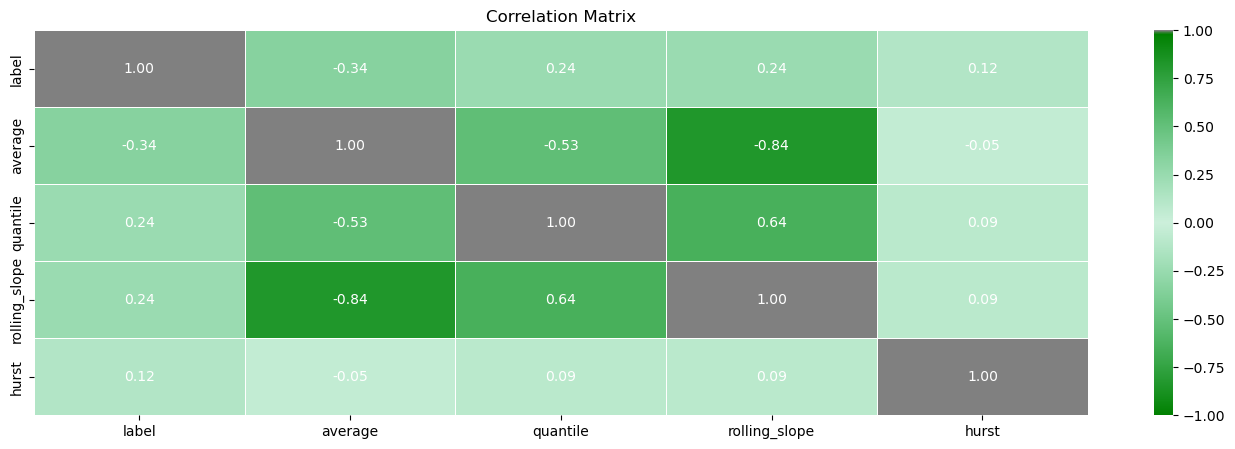

In [83]:
features_df = pd.DataFrame({
    'label': labels_series_lf,
    "average": average,
    "quantile": quantile,
    "rolling_slope": rolling_slope,
    "hurst": hursts,
})

features_correlation(features_df)

III. Framework

In [ ]:
class Strategy(ABC):
    def __init__(self):
        # ======= Adapt columns name to the available data / operational consideration =======
        self.date_name = "date"
        self.bid_open_name = "open"
        self.ask_open_name = "open"
        
        # ======= Store Data used for the strategy =======
        self.data = None
        self.processed_data = None
    
    #*____________________________________________________________________________________ #
    def set_names(self, date_name: str, bid_open_name: str, ask_open_name: str):
        """
        Set the names of the columns used in the data, it is important to ensure the operations are done using the correct price. 
        For daily data, it is common to use the open or close price for both bid and ask. The bid-ask spread is usually estimated as a slippage cost.
        
            - date_name (str) : name of the column containing the dates
            - bid_open_name (str) : name of the column containing the bid open prices at which the strategy will operate
            - ask_open_name (str) : name of the column containing the ask open prices at which the strategy will operate
        """
        self.date_name = date_name
        self.bid_open_name = bid_open_name
        self.ask_open_name = ask_open_name
    
    #*____________________________________________________________________________________ #
    @abstractmethod
    def set_params(self):
        """This method should be used to set the different parameters of the model."""
        pass
    
    #*____________________________________________________________________________________ #
    @abstractmethod
    def load_data(self):
        """This method should be used to load the data."""
        pass

    #*____________________________________________________________________________________ #
    @abstractmethod
    def process_data(self):
        """
        This method should be used to process the data : normalization, feature engineering, etc.
        It is expected to output a list of pd.DataFrame containing the processed data, each element of the list will then be used independtly to predict the signals.
        For daily data, returning a list containing a unique element is enough. Different elements can be used to avoid overnight bias when operating only intraday.
        """
        pass
    
    #*____________________________________________________________________________________ #
    @abstractmethod
    def fit(self):
        """
        This method should be used to train the model, optimize hyperparameters and so on.
        It does not explicitly split samples, this has to be done by the user before calling this method.
        """
        pass
    
    #*____________________________________________________________________________________ #
    @abstractmethod
    def predict(self):
        """
        This method should be used to predict the signals.
        It is expected to return a pd.DataFrame containing the necessary data to compute the operations (signals, price, date, etc.).
        """
        pass

    #*____________________________________________________________________________________ #
    def operate(self, df: pd.DataFrame):
        """
        This method is common to all strategies and is used to extract the operations from the signals.
        The outputs are the operations (each line corresponds to a different trade) and the signals (each line corresponds to a bar with the associated signal) DataFrames.
        
            - df (pd.DataFrame) : DataFrame containing the data used to extract the operations
        """
        # ======= I. Extract signals =======
        signals_df = self.predict(df=df)
        
        # ======= II. Objects initialization before extracting operations =======
        operations_df = pd.DataFrame(columns=['ID', 'Side', 'Entry_Date', 'Entry_Price', 'Exit_Date', 'Exit_Price', 'PnL'])
        
        # II.1 Set first and last signal to 0 to ensure that the operations are closed
        signals_df.reset_index(drop=True, inplace=True)

        signals_df.loc[0, "signal"] = 0
        signals_df.loc[len(signals_df) - 1, "signal"] = 0
        signals_df.loc[len(signals_df) - 2, "signal"] = 0

        # II.2 Extract the Signal Change and the Entry Points
        signals_df["Signal Change"] = signals_df["signal"].diff()
        signals_df["Signal Change"] = signals_df["Signal Change"].shift(1) #! Shifted to avoid look-ahead bias

        entry_points = signals_df[signals_df["Signal Change"] != 0].copy()
        nb_entry = len(entry_points)
        
        # ======= III. Create an Operation for each entry point =======
        sequential_id = 0
        for idx in range(nb_entry - 1):
            # III.1 Extracting rows
            current_row = entry_points.iloc[idx]
            next_row = entry_points.iloc[idx + 1]
            previous_row = signals_df.iloc[current_row.name - 1]

            # III.2 Extract Information for a Long Operation
            if (current_row["Signal Change"] > 0 and previous_row["signal"] == 1):
                side = 1
                entry_date = current_row[self.date_name]
                entry_price = current_row[self.ask_open_name]
                exit_date = next_row[self.date_name]
                exit_price = next_row[self.bid_open_name]
                pnl = (exit_price - entry_price)

            # III.3 Extract Information for a Short Operation
            elif (current_row["Signal Change"] < 0 and previous_row["signal"] == -1):
                side = -1
                entry_date = current_row[self.date_name]
                entry_price = current_row[self.bid_open_name]
                exit_date = next_row[self.date_name]
                exit_price = next_row[self.ask_open_name]
                pnl = (entry_price - exit_price)

            else:
                continue

            # III.4 Append Operation to the DataFrame
            operations_df.loc[sequential_id] = [
                sequential_id,
                side,
                entry_date,
                entry_price,
                exit_date,
                exit_price,
                pnl,
            ]

            # --- New sequential id for the next loop iteration ---
            sequential_id += 1
        
        return operations_df, signals_df



In [ ]:
"""
We first define some functions to compute the performance metrics of a given strategy.
"""

def get_distribution(returns_series: pd.Series, frequence: str = "daily"):
    """
    - Expected Return: The annualized mean return, indicating average performance.
    - Volatility: Standard deviation of returns, representing total risk.
    - Downside Deviation: Standard deviation of negative returns, used in risk-adjusted metrics like Sortino Ratio.
    - Median Return: The median of returns, a measure of central tendency.
    - Skew & Kurtosis: Describe the distribution shape, with skew indicating asymmetry and kurtosis indicating tail heaviness.
    """
    # ======= I. Get the right frequence =======
    frequence_dict = {"daily": 252, "5m": 19656, "1m": 98280}
    adjusted_frequence = frequence_dict[frequence]
    
    # ======= II. Compute the statistics =======
    expected_return = returns_series.mean() * adjusted_frequence
    volatility = returns_series.std() * np.sqrt(adjusted_frequence)
    downside_deviation = returns_series[returns_series < 0].std() * np.sqrt(adjusted_frequence) if returns_series[returns_series < 0].sum() != 0 else 0
    median_return = returns_series.median() * adjusted_frequence
    skew = returns_series.skew()
    kurtosis = returns_series.kurtosis()
    
    # ======= III. Store the statistics =======
    distribution_stats = {
        "expected_return": expected_return,
        "volatility": volatility,
        "downside_deviation": downside_deviation,
        "median_return": median_return,
        "skew": skew,
        "kurtosis": kurtosis,
    }
    
    return distribution_stats

# ____________________________________________________________________________________ #
def get_risk_measures(returns_series: pd.Series):
    """
    - Maximum Drawdown: Largest observed loss from peak to trough, a measure of downside risk.
    - Max Drawdown Duration: Longest period to recover from drawdown, indicating risk recovery time.
    - VaR 95 and CVaR 95: Value at Risk and Conditional Value at Risk at 95%, giving the maximum and average expected losses in worst-case scenarios.
    """
    # ======= I. Compute the Cumulative returns =======    
    cumulative_returns = (1 + returns_series).cumprod()
    
    # ======= II. Compute the statistics =======
    # ------ Maximum Drawdown and Duration
    running_max = cumulative_returns.cummax().replace(0, 1e-10)
    drawdown = (cumulative_returns / running_max) - 1
    drawdown_durations = (drawdown < 0).astype(int).groupby((drawdown == 0).cumsum()).cumsum()

    maximum_drawdown = drawdown.min()
    max_drawdown_duration = drawdown_durations.max()

    # ------ Value at Risk and Conditional Value at Risk
    var_95 = returns_series.quantile(0.05)
    cvar_95 = returns_series[returns_series <= var_95].mean()
    
    # ======= III. Store the statistics =======
    risk_stats = {
        "drawdown": drawdown,
        "maximum_drawdown": maximum_drawdown,
        "max_drawdown_duration": max_drawdown_duration,
        "var_95": var_95,
        "cvar_95": cvar_95,
    }
    
    return risk_stats

# ____________________________________________________________________________________ #
def get_market_sensitivity(returns_series: pd.Series, market_returns: pd.Series, frequence: str = "daily"):
    """
    - Beta: Sensitivity to market movements.
    - Alpha: Risk-adjusted return above the market return.
    - Upside/Downside Capture Ratios: Percent of market gains or losses captured by the investment.
    - Tracking Error: Volatility of return differences from the market.
    """
    # ======= I. Get the right frequence =======
    frequence_dict = {"daily": 252, "5m": 19656, "1m": 98280}
    adjusted_frequence = frequence_dict[frequence]
    
    # ======= II. Compute the statistics =======
    # ------ Beta and Alpha (Jensens's)
    beta = returns_series.cov(market_returns) / market_returns.var()
    alpha = returns_series.mean() * adjusted_frequence - beta * (market_returns.mean() * adjusted_frequence)
    
    # ------ Capture Ratios
    upside_capture = returns_series[market_returns > 0].mean() / market_returns[market_returns > 0].mean()
    downside_capture = returns_series[market_returns < 0].mean() / market_returns[market_returns < 0].mean()

    # ------ Tracking Error
    tracking_error = returns_series.sub(market_returns).std() * np.sqrt(adjusted_frequence)
    
    # ======= III. Store the statistics =======
    market_sensitivity_stats = {
        "beta": beta,
        "alpha": alpha,
        "upside_capture": upside_capture,
        "downside_capture": downside_capture,
        "tracking_error": tracking_error,
    }
    
    return market_sensitivity_stats

# ____________________________________________________________________________________ #
def get_performance_measures(returns_series: pd.Series, market_returns: pd.Series, risk_free_rate: float = 0.0, frequence: str = "daily"):
    """
    - Sharpe Ratio: Risk-adjusted returns per unit of volatility.
    - Sortino Ratio: Risk-adjusted return accounting only for downside volatility.
    - Treynor Ratio: Return per unit of systematic (market) risk.
    - Information Ratio: Excess return per unit of tracking error.
    - Sterling Ratio: Return per unit of average drawdown.
    - Calmar Ratio: Return per unit of maximum drawdown.
    """
    # ======= I. Get the right frequence =======
    frequence_dict = {"daily": 252, "5m": 19656, "1m": 98280}
    adjusted_frequence = frequence_dict[frequence]
    
    # ======= II. Extract Statistics =======
    distribution_stats = get_distribution(returns_series, frequence)
    expected_return = distribution_stats["expected_return"]
    volatility = distribution_stats["volatility"]
    downside_deviation = distribution_stats["downside_deviation"]
    
    risk_stats = get_risk_measures(returns_series)
    drawdown = risk_stats["drawdown"]
    maximum_drawdown = risk_stats["maximum_drawdown"]
    
    market_sensitivity_stats = get_market_sensitivity(returns_series, market_returns, frequence)
    beta = market_sensitivity_stats["beta"]
    tracking_error = market_sensitivity_stats["tracking_error"]
    
    # ======= III. Compute the ratios =======
    # ------ Sharpe, Sortino, Treynor, and Information Ratios
    sharpe_ratio = (expected_return - risk_free_rate) / volatility if volatility != 0 else 0
    sortino_ratio = expected_return / downside_deviation if downside_deviation != 0 else 0
    treynor_ratio = expected_return / beta if beta != 0 else 0
    information_ratio = (expected_return - market_returns.mean() * adjusted_frequence) / tracking_error if tracking_error != 0 else 0

    # ------ Sterling, and Calmar Ratios
    average_drawdown = abs(drawdown[drawdown < 0].mean()) if drawdown[drawdown < 0].sum() != 0 else 0
    sterling_ratio = (expected_return - risk_free_rate) / average_drawdown if average_drawdown != 0 else 0
    calmar_ratio = expected_return / abs(maximum_drawdown) if maximum_drawdown != 0 else 0
    
    # ======= IV. Store the statistics =======
    performance_stats = {
        "sharpe_ratio": sharpe_ratio,
        "sortino_ratio": sortino_ratio,
        "treynor_ratio": treynor_ratio,
        "information_ratio": information_ratio,
        "sterling_ratio": sterling_ratio,
        "calmar_ratio": calmar_ratio,
    }
    
    return performance_stats, (distribution_stats, risk_stats, market_sensitivity_stats)


In [ ]:
"""
Now we can define a Backtest class. This class will be used to run the backtest of a given strategy.
"""

class Backtest():
    def __init__(self, strategy: Strategy, brokerage_cost: float = 0.0, slippage_cost: float = 0.0):
        # ======= Backtest parameters =======
        self.ticker = None
        self.start_date = None
        self.end_date = None
        self.strategy_params = None
        
        self.brokerage_cost = brokerage_cost
        self.slippage_cost = slippage_cost
        
        self.n_jobs = 1
        
        # ======= Strategy inputs=======
        self.strategy = strategy
        self.data = None
        self.processed_data = None

        # ======= Backtest results =======
        self.signals_dfs = None
        self.operations_dfs = None
        self.full_operations_df = None
        self.full_signals_df = None

    #*____________________________________________________________________________________ #
    def set_computingParams(self, date_name: str, bid_open_name: str, ask_open_name: str, n_jobs: int = 1):
        """
        This method is used to set the different parameters to ensure the correct computation of the operations.
        
            - date_name (str) : name of the column containing the dates
            - bid_open_name (str) : name of the column containing the bid open prices at which the strategy will operate
            - ask_open_name (str) : name of the column containing the ask open prices at which the strategy will operate
            - n_jobs (int) : number of jobs to run in parallel
        """
        self.strategy.set_names(date_name=date_name, bid_open_name=bid_open_name, ask_open_name=ask_open_name)
        self.n_jobs = n_jobs
    
    #*____________________________________________________________________________________ #
    def set_backtestParams(self, ticker: str, start_date: str, end_date: str, strategy_params: dict):
        """
        This method is used to set the different parameters of the backtest.
        
            - ticker (str) : ticker of the asset to backtest
            - start_date (str) : start date of the backtest
            - end_date (str) : end date of the backtest
            - strategy_params (dict) : parameters of the strategy
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.strategy_params = strategy_params
    
    #*____________________________________________________________________________________ #
    def run_strategy(self):
        """
        This method is used to run the strategy and extract the operations.
        """
        # ======= I. Set up Parameters and Data =======
        self.strategy.set_params(**self.strategy_params)
        data = self.strategy.load_data(self.ticker, self.start_date, self.end_date)
        processed_data = self.strategy.process_data()
        
        # I.2 Store the data
        self.data = data
        self.processed_data = processed_data
        
        # ======= II. Run the Strategy =======
        if self.n_jobs > 1:
            #! Be aware that the strategy should be thread-safe and to keep track of the timestamps to reconstitute the operations later.
            operations_dfs, signals_dfs = Parallel(n_jobs=self.n_jobs)(delayed(self.strategy.operate)(data_group) for data_group in processed_data)
        else:
            operations_dfs = []
            signals_dfs = []
            for data_group in processed_data:
                operations_df, signals_df = self.strategy.operate(data_group)
                operations_dfs.append(operations_df)
                signals_dfs.append(signals_df)
        
        full_operations_df = pd.concat(operations_dfs, ignore_index=True, axis=0)
        full_signals_df = pd.concat(signals_dfs, ignore_index=True, axis=0)
        
        return full_operations_df, full_signals_df, operations_dfs, signals_dfs
    
    #*____________________________________________________________________________________ #
    def apply_slippage(self, operations_df: pd.DataFrame):
        """
        This method is used to apply the slippage on the operations by modifying the entry and exit prices.
        
            - operations_df (pd.DataFrame) : DataFrame containing the operations
        """
        # ======= I. Ensure there are operations =======
        adjusted_operations_df = operations_df.copy()
        if operations_df.empty:
            return adjusted_operations_df

        # ======= II. Apply slippage on Entry/Exit prices =======
        # II.1 Adjust entry prices
        adjusted_operations_df["Entry_Price_Adjusted"] = adjusted_operations_df.apply(
            lambda row: row["Entry_Price"] * (1 + self.slippage_cost) if row["Side"] == 1 else row["Entry_Price"] * (1 - self.slippage_cost), axis=1
        )

        # II.2 Adjust exit prices
        adjusted_operations_df["Exit_Price_Adjusted"] = adjusted_operations_df.apply(
            lambda row: row["Exit_Price"] * (1 - self.slippage_cost) if row["Side"] == 1 else row["Exit_Price"] * (1 + self.slippage_cost), axis=1
        )

        # ======= III. Adjust the PnL =======
        adjusted_operations_df["PnL_Adjusted"] = (adjusted_operations_df["Exit_Price_Adjusted"] - adjusted_operations_df["Entry_Price_Adjusted"]) * adjusted_operations_df["Side"]

        return adjusted_operations_df
    
    #*____________________________________________________________________________________ #
    def apply_brokerage(self, operations_df: pd.DataFrame):
        """
        This method is used to apply the brokerage cost on the operations by modifying the PnL.
        
            - operations_df (pd.DataFrame) : DataFrame containing the operations
        """
        # ======= I. Ensure there are operations =======
        adjusted_operations_df = operations_df.copy()
        if operations_df.empty:
            return adjusted_operations_df

        # ======= II. Apply brokerage on PnL =======
        adjusted_operations_df["PnL_Adjusted"] = adjusted_operations_df["PnL_Adjusted"] - (self.brokerage_cost * np.abs(adjusted_operations_df["Entry_Price"]))

        return adjusted_operations_df

    #*____________________________________________________________________________________ #
    def run_backtest(self):
        """
        This method is used to run the backtest.
        """
        # ======= I. Run the Strategy =======
        full_operations_df, full_signals_df, operations_dfs, signals_dfs = self.run_strategy()
        full_operations_df = self.apply_slippage(full_operations_df)
        full_operations_df = self.apply_brokerage(full_operations_df)
        
        # ======= II. Compute the Cumulative Returns : Operations bars =======
        # II.1 Without Fees
        full_operations_df['NoFees_strategy_returns'] = full_operations_df['PnL'] / full_operations_df['Entry_Price']
        full_operations_df['NoFees_strategy_cumret'] = (1 + full_operations_df['NoFees_strategy_returns']).cumprod()
        
        # II.2 With Fees
        full_operations_df['strategy_returns'] = full_operations_df['PnL_Adjusted'] / full_operations_df['Entry_Price']
        full_operations_df['strategy_cumret'] = (1 + full_operations_df['strategy_returns']).cumprod()
        
        # II.3 Buy and Hold
        full_operations_df['BuyAndHold_returns'] = (full_operations_df['Exit_Price'] - full_operations_df['Entry_Price']) / full_operations_df['Entry_Price']
        full_operations_df['BuyAndHold_cumret'] = (1 + full_operations_df['BuyAndHold_returns']).cumprod()

        # ======= III. Compute the Cumulative Returns : Time bars =======
        # For this part, we don't consider the fees and slippage as this computation is relevant only for very low frequency strategies which are less impacted by these costs.
        name_series = self.strategy.ask_open_name
        full_signals_df['BuyAndHold_returns'] = (full_signals_df[name_series].shift(-1) - full_signals_df[name_series]) / full_signals_df[name_series]
        full_signals_df['BuyAndHold_cumret'] = (1 + full_signals_df['BuyAndHold_returns']).cumprod()
        full_signals_df['strategy_returns'] = full_signals_df['signal'].shift(-1) * full_signals_df['BuyAndHold_returns']
        full_signals_df['strategy_cumret'] = (1 + full_signals_df['strategy_returns']).cumprod()

         # ======= IV. Compute statistics =======
        returns_series = full_operations_df['strategy_returns']
        market_returns = full_operations_df['BuyAndHold_returns']
        operation_stats, _ = get_performance_measures(returns_series, market_returns, frequence="daily")

        returns_series = full_signals_df['strategy_returns']
        market_returns = full_signals_df['BuyAndHold_returns']
        time_stats, _ = get_performance_measures(returns_series, market_returns, frequence="daily")
        
        # ======= IV. Store the results =======
        self.full_operations_df = full_operations_df
        self.full_signals_df = full_signals_df
        self.operations_dfs = operations_dfs
        self.signals_dfs = signals_dfs
        
        return full_operations_df, full_signals_df, operation_stats, time_stats
        
    #*____________________________________________________________________________________ #
    def plot_operationsBars(self, by_date: bool = False, BuyAndHold: bool = True, NoFees: bool = True, Fees: bool = True):
        """
        Plots the strategy's cumulative returns based on executed trades.  
        This method intentionally excludes daily portfolio valuation to avoid overestimating result significance.
        """
        # ======= I. Prepare the DataFrame for plotting =======
        plotting_df = self.full_operations_df.copy()

        # ======= II. Initialize the plot =======
        sns.set_style("whitegrid")
        colors = sns.color_palette("husl", 3)
        plt.figure(figsize=(17, 6))
        
        if by_date:
            plotting_df = plotting_df.set_index(plotting_df['Entry_Date'])
            plt.xlabel('Date', fontsize=14, fontweight='bold')
        else:
            plt.xlabel('Number of Trades', fontsize=14, fontweight='bold')
        
        plt.ylabel('Cumulative Returns', fontsize=14, fontweight='bold')
        plt.title('Strategy Performance Comparison', fontsize=16, fontweight='bold')

        # ======= III. Plot the Cumulative Returns =======
        if BuyAndHold:
            plt.plot(plotting_df['BuyAndHold_cumret'], label='Buy and Hold', color=colors[0], linewidth=2)
        if NoFees:
            plt.plot(plotting_df['NoFees_strategy_cumret'], label='Cumulative Returns Without Fees', color=colors[1], linestyle='--', linewidth=1)
        if Fees:
            plt.plot(plotting_df['strategy_cumret'], label='Cumulative Returns Adjusted', color=colors[2], linewidth=2)

        plt.legend(fontsize=12, loc='best', frameon=True, shadow=True)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
    
    #*____________________________________________________________________________________ #
    def plot_timeBars(self):
        """
        This method is used to plot the strategy's cumulative returns based on time bars.
        """
        # ======= I. Prepare the DataFrame for plotting =======
        date_name = self.strategy.date_name
        plotting_df = self.full_signals_df.copy()
        plotting_df = plotting_df.set_index(plotting_df[date_name])

        # ======= II. Initialize the plot =======
        sns.set_style("whitegrid")
        colors = sns.color_palette("husl", 3)
        plt.figure(figsize=(17, 6))
        
        plt.xlabel('Date', fontsize=14, fontweight='bold')
        plt.ylabel('Cumulative Returns', fontsize=14, fontweight='bold')
        plt.title('Strategy Performance Comparison', fontsize=16, fontweight='bold')

        # ======= III. Plot the Cumulative Returns =======
        plt.plot(plotting_df['BuyAndHold_cumret'], label='Buy and Hold', color=colors[0], linewidth=2)
        plt.plot(plotting_df['strategy_cumret'], label='Cumulative Returns Adjusted', color=colors[2], linewidth=2)

        plt.legend(fontsize=12, loc='best', frameon=True, shadow=True)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

        

IV. Model